# How do Autrian courts cite each other?

Zur Beantwortung der Frage, müssen gerichtliche Entscheidungen analysiert werden.
Zunächst müssen die Entscheidungen daher aus dem RIS ermittelt werden.

# 1. Load or generate Testdata

Um das RIS nicht immer bemühen zu müssen, wurden Entscheidungen in Dateien zwischengespeichert

In [4]:
#imports
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import graphviz
import unicodedata
import calendar
import time
from matplotlib import pyplot as plt
import itertools 


Um den Zugang zu Entscheidungen zu erleichtern, wird der ris-API-wrapper von PhilippTh (https://github.com/PhilippTh) genutzt. Vor dem Einbinden ist dessen Lizenz zu prüfen und einzuhalten!

In [10]:

# clone ris-API-wrapper repository from PhilippTh (https://github.com/PhilippTh) - check license before cloning and using
!git clone https://github.com/PhilippTh/ris-API-wrapper.git

# navigate to atalaia directory
%cd ris-API-wrapper/
!ls

# get modifications made on the repo
!git pull origin main

# install packages requirements
#!pip install -r requirements.txt

#from risApiWrapper import Helper
from risApiWrapper.Judikatur import Justiz
from risApiWrapper.Judikatur import Vfgh
from risApiWrapper.Judikatur import Vwgh

Cloning into 'ris-API-wrapper'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 186 (delta 86), reused 152 (delta 58), pack-reused 0
Receiving objects: 100% (186/186), 60.21 KiB | 1010.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/ris-API-wrapper/ris-API-wrapper/ris-API-wrapper
LICENSE  README.md  requirements.txt  risApiWrapper  tests
From https://github.com/PhilippTh/ris-API-wrapper
 * branch            main       -> FETCH_HEAD
Already up to date.


# 1.1 Read created Test-Data

In [26]:
#Read test data from github
#store test data in dictionary for easier data handling
dataframes={}
for organ in ["OGH","VwGH","VfGH"]:
     dataframes[organ] = pd.read_pickle("https://github.com/michael-l-AT/test-data/raw/main/"+organ+"_E.pkl")


In [27]:
#uncomment to reduce the amount of test data (this sppeeds up the programm)


for organ in ["OGH","VwGH","VfGH"]:
     dataframes[organ] = dataframes[organ].truncate(after=99)

## 1.2 Alternatively Create Test-Data

Es werden alle Entscheidungen der Jahre 2020 und 2021 herunterleladen und zwischengespeichert

In [13]:
#get text of decisions - mind the sleeptime (="nice value" to reduce load on RIS)

def get_html(document_url,sleeptime:int=5):
    #print(xml_url)
    r_volltext=requests.get(document_url).content
    soup=BeautifulSoup(r_volltext,"lxml").find('div', class_='documentContent').text
    soup=unicodedata.normalize("NFKD", soup)
    time.sleep(sleeptime)  # time to wait in order to reduce requests on RIS
    return(soup)

In [ ]:
#Get decisions by month - due to "nice" value (check "time.sleep" in get_html) this will tage ages

for organ in ["OGH","VwGH","VfGH"]:
    for year in [2020,2021]:
        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            date_from=str(year)+"-"+month+"-01"
            date_to=str(str(year)+"-"+month+"-"+str(calendar.monthrange(int(year), int(month))[1]))
            
            print(f"Getting decisions from {date_from} to {date_to}")
            if organ == "OGH":
                E=Justiz(court="OGH",show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)
            
            if organ == "VwGH":
                E=Vwgh(show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)
            
            if organ == "VfGH":
                E=Vfgh(show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)

            
            df = pd.DataFrame(E._results)
            if len(df): # store dataframe only if decicions were found 
                df['case_number']= df['case_number'].apply(lambda x: str(x[0]) )
                df['Volltext']=df.apply(lambda x: get_html(x['document_url']), axis=1)
                df.to_pickle(organ+"_"+str(year)+"_"+str(month)+".pkl")



In [ ]:
#Concat decisions

dataframes={}
for organ in ["OGH","VwGH","VfGH"]:
    decisions = []
    for year in [2020,2021]:
        #print(year)

        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            try:
                decisions.append(pd.read_pickle(organ+"_"+str(year)+"_"+str(month)+".pkl"))
            #print(decisions)
            except FileNotFoundError:
                print("No decitions in this month")
            except Exception as e:
                print(repr(e))
                raise Exception("Exception")

    
    #print(decisions)
    dataframes[organ] = pd.concat(decisions, ignore_index=True)
    dataframes[organ].to_pickle(organ+"_2020_2021.pkl")
        
        


### 1.2.1 Create custom test data for organs using RIS-parameters

Alternativ können Entscheidungen auch anhand bestimmter Parameter ausgewählt werden

In [12]:
# Alternatively get decisions by parameters (eg. date - see RIS-API-Wraper for parameters)
OGH_E=Justiz(court="OGH",show_rechtssaetze=False,decision_date_from="2021-11-20")

In [ ]:
df_OGH = pd.DataFrame(OGH_E._results)
df_OGH['case_number']= df_OGH['case_number'].apply(lambda x: str(x[0]) ) # convert to string for easier handling

In [ ]:
df_OGH['Volltext']=df_OGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["OGH"]=df_OGH

In [ ]:
display(dataframes["OGH"])

### 1.2.2 VfGH

In [11]:
#get decisions by date
VfGH_E=Vfgh(show_rechtssaetze=False,decision_date_from="2021-04-28")

In [ ]:
df_VfGH = pd.DataFrame(VfGH_E._results)
df_VfGH['case_number']= df_VfGH['case_number'].apply(lambda x: str(x[0]) )

In [ ]:
df_VfGH['Volltext']=df_VfGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["VfGH"]=df_VfGH

In [ ]:
display(dataframes["VfGH"])

### 1.2.3 VwGH

In [ ]:
#get decisions by date
VwGH_E=Vwgh(show_rechtssaetze=False,decision_date_from="2021-10-15")

In [ ]:
df_VwGH = pd.DataFrame(VwGH_E._results)
df_VwGH['case_number']= df_VwGH['case_number'].apply(lambda x: str(x[0]) )

In [ ]:
df_VwGH['Volltext']=df_VwGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["VwGH"]=df_VwGH

In [ ]:
display(dataframes["VwGH"])

# 2. Find cited decisions (regex-Patterns)

Innerhalb von Entscheidungen sollen zitierte Entscheidungen aufgefunden werden. Die Erstellung eines möglichst passenden regex-Musters stellte die größte Herausforderung dar.

Wahrscheinlich können alle regex-Muster verbessert / optimiert werden.

Um die Anzahl von fälschlicherweise erkannten Zitierungen zu verhindern, könnte eine Gegenprüfung durch das RIS angestellt werden. Nur Entscheidungen, die sich auch im RIS auffinden lassen, könnten als (valide) Zitierungen erachtet werden. Zur Entlastung der RIS-API wurde dieser Schritt aber nicht durchgeführt.

In [33]:
#find cited decisions
def find_citings (case_number:str,text:str,organ:str):
  #print(case_number)
  citings =set() # use a set to only list unique citings
  citings.clear()
  pattern=""
  if organ =="OGH":
    #§ 40 OGH-Geo 2019 (1) Das Aktenzeichen besteht aus der Senatszahl, dem Gattungszeichen, der Aktenzahl, den beiden letzten Ziffern des Anfalljahrs sowie in den IT-gestützt geführten Registerfällen aus einem Prüfzeichen, zB: 3 Ob 127/19i; 1 Nc 20/17p; 11 Os 93/19k.
    pattern='([0-9]{1,3} ?(O|D|P|D|N|G|F|E|R)[A-Za-zäöü]{1,3} ?([0-9]{1,3})\/[0-9]{2}[a-z])' #needs to be improved
  if organ =="VfGH":
    pattern='(((E|A|UA|G|WI|V|SV|KI) ?[0-9]{1,4}\/[0-9]{4})(?![a-z])( ua)?)' # needs to be improved (lots of false positives - decisions prior 2000 are not found)

  if organ =="VfGH_Slg":
    pattern='((?:(?<=VfSlg\. )|(?<=VfSlg )).{1,7}(?=\/\d{4}))'  

  if organ =="VwGH":
    pattern='(((R[a|o] ?)|(Fr ?))[0-9]{1,4}/[0-9]{2}/[0-9]{4})' # needs to be improved
    
  if organ =="VwGH_Slg":
    pattern='(VwSlg\.? .{1,8}\/\d{4})'
    
  
  
  
  for m in re.finditer(pattern,text): # ! Regex is not correct needs to be redefined
  
    citings.add(replace_GZ(m,organ))
  
  citings.discard(case_number) #remove self "citings"
    
  #one could add a check, if all citings are found in RIS here - not done in order to reduce load on RIS-API  

  
  return citings






In [34]:
# Helper Function to provide removesuffix in oder python versions
def remove_suffix(input_string, suffix):
    if suffix and input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string

In [35]:
# Helper Function to transform case_numbers to format used in RIS
def replace_GZ(m,organ):
  ris_gz=m.group(0)
  #print(m.group(0))
  if (organ != "VwGH" and organ != "VwGH_Slg"): # VwGH has spaces in case_numbers
    ris_gz=m.group(0).replace(" ", "")
  if (organ =="VfGH"):
    ris_gz=remove_suffix(m.group(0),'ua')
  return ris_gz

In [36]:
def add_citings(dataframe):
    #print(dataframe)
    for cited_organ in ["OGH","VfGH","VfGH_Slg","VwGH","VwGH_Slg"]:
        dataframe[cited_organ+'_citings']=dataframe.apply(lambda x: find_citings(x['case_number'],x['Volltext'],cited_organ), axis=1)
    

In [37]:
for organ_dataframe in dataframes.values():
    add_citings(organ_dataframe)

## 2.1 For further analysis one could check cited decisions in already cited decisions (recursion)

Um das Zitierverhalten von Gerichten weiter zu analysieren, kann analysiert werden, welche Entscheidungen die zitierten Entscheidungen zitieren. Dies könnte je nach Anzahl der Rekursionen könnte dies sehr lange dauern.

In [23]:
#function to recursively find cited decisions in originally cited decisions
def find_citings_recursive (organ:str,cited_organ:str,case_numbers:set,num_calls:int=0,sleeptime:int=5):
  if isinstance(case_numbers,set) and len(case_numbers)>0:
    for case_number in case_numbers:
        
        #print(case_number)
        if not case_number in dataframes[cited_organ]["case_number"].values: # if decision was already checked, skip it
            if cited_organ=="OGH":
                result = None
                result=Justiz(court="OGH",show_rechtssaetze=False,case_number=case_number)
            if cited_organ=="VwGH":
                result = None
                result=Vwgh(show_rechtssaetze=False,case_number=case_number)
            if cited_organ=="VfGH":
                result = None
                result=Vfgh(show_rechtssaetze=False,case_number=case_number)
            
            
            try: # test if the decision text can be fetched 
                if result._results[0]['document_url']:
                    volltext=get_html(result._results[0]['document_url'],sleeptime)
                    citings=find_citings (case_number,volltext,cited_organ)
                    print(f'checking: {case_number} - found: {citings}') # output to keep the user informed
                    cited_colum=cited_organ+"_citings"
                    
                    
                    #according to forum-posts adding rows to dataframe is a bad idea
                    # this could be reworked to use lists insted and combine them
                    
                    new_row={'case_number': case_number, cited_colum: citings, 'Volltext': volltext,'document_url':result._results[0]['document_url']}
                    dataframes[cited_organ] = dataframes[cited_organ].append(new_row, ignore_index = True)
                    
                    
                    # save as pickle to be able to resume if programm crashes - or takes to long
                    dataframes[cited_organ].to_pickle(cited_organ+"_recursive.pkl") 
                    
                    
                    if num_calls == 0:
                        continue
                    find_citings_recursive(organ,cited_organ,citings,num_calls-1)
                    
            except IndexError:
                #if response does not contain Key(s) for any reason also return nothing 
                print("Decision not found:",case_number)
                continue # with next case_number
            except Exception as e:
                print(repr(e))
                raise Exception("Exception")
              


  else: # no decisions were cited
    return("")

In [ ]:
#find citings recursively - set number of "recursions"
for organ in ["OGH","VwGH","VfGH"]:
    for cited_organ in ["OGH","VwGH","VfGH"]:
        restult=[find_citings_recursive(organ,cited_organ,case_numbers,0,1) for case_numbers in dataframes[organ][cited_organ+'_citings']] #set number of revisions to a higher number to look even "deeper"

In [38]:
for organ_dataframe in dataframes.values():
    display(organ_dataframe)

,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_citings,VwGH_Slg_citings
0,Entscheidungstext,,6Ob197/21w,[ECLI:AT:OGH0002:2021:0060OB00197.21W.1118.000],OGH,2021-11-18,2021-11-26,2021-11-26,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}
1,Entscheidungstext,,12Os136/21y,[ECLI:AT:OGH0002:2021:0120OS00136.21Y.1117.000],OGH,2021-11-17,2021-11-24,2021-11-24,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{11Os146/15b},{},{},{},{}
2,Entscheidungstext,,14Os122/21d,[ECLI:AT:OGH0002:2021:0140OS00122.21D.1116.000],OGH,2021-11-16,2021-11-24,2021-11-24,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}
3,Entscheidungstext,,6Ob204/21z,[ECLI:AT:OGH0002:2021:0060OB00204.21Z.1115.000],OGH,2021-11-15,2021-11-25,2021-11-25,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{6Ob26/12k, 6Ob242/20m, 6Ob152/17x, 2Ob130/08v...",{},{},{},{}
4,Entscheidungstext,,12Os129/21v,[ECLI:AT:OGH0002:2021:0120OS00129.21V.1110.000],OGH,2021-11-10,2021-11-19,2021-11-19,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Entscheidungstext,,13Os54/21x,[ECLI:AT:OGH0002:2021:0130OS00054.21X.0929.000],OGH,2021-09-29,2021-11-03,2021-11-03,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{11Os156/17a},{},{},{},{}
96,Entscheidungstext,,13Os55/21v,[ECLI:AT:OGH0002:2021:0130OS00055.21V.0929.000],OGH,2021-09-29,2021-10-19,2021-10-19,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}
97,Entscheidungstext,,13Os59/21g,[ECLI:AT:OGH0002:2021:0130OS00059.21G.0929.000],OGH,2021-09-29,2021-11-08,2021-11-08,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{15Os92/17v, 15Os15/17w, 13Os75/18f}",{},{},{},{}
98,Entscheidungstext,,13Os62/21y,[ECLI:AT:OGH0002:2021:0130OS00062.21Y.0929.000],OGH,2021-09-29,2021-11-08,2021-11-08,,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}


,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_citings,VwGH_Slg_citings
0,Entscheidungstext,None,1466/60,[ECLI:AT:VWGH:9161:1960001466.X00],Verwaltungsgerichtshof (VwGH),9161-11-09,2018-06-18,2018-06-18,[KollVG 1947 §3 Abs1 Z2 litc;],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},{}
1,Entscheidungstext,None,Ra 2021/03/0150,[ECLI:AT:VWGH:2021:RA2021030150.L01],Verwaltungsgerichtshof (VwGH),2021-11-15,2021-11-25,2021-11-25,[Auswertung in Arbeit!],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{E 1944/2021},{},"{Ra 2021/19/0032, Ra 2019/18/0165, Ra 2019/18/...",{}
2,Entscheidungstext,None,Ra 2021/12/0027,[ECLI:AT:VWGH:2021:RA2021120027.L00],Verwaltungsgerichtshof (VwGH),2021-11-08,2021-11-25,2021-11-25,[Auswertung in Arbeit!],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},"{Ra 2020/12/0025, Ra 2016/12/0095}",{}
3,Entscheidungstext,None,Ra 2021/16/0079,[ECLI:AT:VWGH:2021:RA2021160079.L00],Verwaltungsgerichtshof (VwGH),2021-11-08,2021-11-22,2021-11-22,[Auswertung in Arbeit!],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},"{Ra 2019/05/0331, Ra 2020/16/0081, Ra 2021/16/...",{}
4,Entscheidungstext,None,Ra 2021/06/0196,[ECLI:AT:VWGH:2021:RA2021060196.L00],Verwaltungsgerichtshof (VwGH),2021-11-05,2021-11-26,2021-11-26,[Auswertung in Arbeit!],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{Ra 2021/05/0048},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Entscheidungstext,None,Ra 2021/19/0222,[ECLI:AT:VWGH:2021:RA2021190222.L00],Verwaltungsgerichtshof (VwGH),2021-10-20,2021-11-17,2021-11-17,[Auswertung in Arbeit!],https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{Ra 2020/19/0441},{}
96,Entscheidungstext,None,Ra 2021/20/0034,[ECLI:AT:VWGH:2021:RA2021200034.L00],Verwaltungsgerichtshof (VwGH),2021-10-20,2021-11-16,2021-11-16,"[BFA-VG 2014 §9, B-VG Art133 Abs4, FrPolG 2005...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},"{Ra 2020/20/0408, Ra 2021/14/0013, Ra 2020/20/...",{}
97,Entscheidungstext,None,Ra 2021/20/0239,[ECLI:AT:VWGH:2021:RA2021200239.L00],Verwaltungsgerichtshof (VwGH),2021-10-20,2021-11-16,2021-11-16,"[AVG §68 Abs1, B-VG Art133 Abs4, VwGG §28 Abs3...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},"{Ra 2020/20/0425, Ra 2020/18/0537, Ra 2020/20/...",{}
98,Entscheidungstext,None,Ra 2021/20/0246,[ECLI:AT:VWGH:2021:RA2021200246.L00],Verwaltungsgerichtshof (VwGH),2021-10-20,2021-11-15,2021-11-17,"[AsylG 1997 §13 Abs2, AsylG 2005 §3 Abs1, Asyl...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},"{Ro 2019/19/0006, Ra 2017/19/0531, Ra 2017/18/...",{}


,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_citings,VwGH_Slg_citings
0,Entscheidungstext,None,E4080/2020 ua,[ECLI:AT:VFGH:2021:E4080.2020],Verfassungsgerichtshof (VfGH),2021-10-07,None,2021-11-26,"[PersFrSchG Art1, EMRK Art5, FremdenpolizeiG 2...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{E4080/2020 },"{17.317, 13.708}",{Ra 2020/21/0404},{}
1,Entscheidungstext,None,A5/2021,[ECLI:AT:VFGH:2021:A5.2021],Verfassungsgerichtshof (VfGH),2021-10-07,None,2021-11-25,"[B-VG Art10 Abs1 Z3, B-VG Art10 Abs1 Z7, B-VG ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{A8/2019},"{19.034, 20.177, 18.613, 17.942, 20.284}",{},{}
2,Entscheidungstext,None,E93/2021,[ECLI:AT:VFGH:2021:E93.2021],Verfassungsgerichtshof (VfGH),2021-10-07,None,2021-11-26,"[PersFrSchG Art1, FremdenpolizeiG 2005 §76, §8...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{13.708},{Ra 2020/21/0404},{}
3,Entscheidungstext,None,E837/2021,[ECLI:AT:VFGH:2021:E837.2021],Verfassungsgerichtshof (VfGH),2021-10-07,None,2021-11-16,"[BVG-Rassendiskriminierung ArtI Abs1, VwGVG §2...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{E2059/2020 , E163/2014, E720/2021, E671/2019}","{14.393, 13.836, 14.650, 19.965, 15.451, 16.21...","{Ra 2017/02/0050, Ro 2014/04/0068, Fr 2015/03/...",{}
4,Entscheidungstext,None,E1677/2021,[ECLI:AT:VFGH:2021:E1677.2021],Verfassungsgerichtshof (VfGH),2021-10-07,None,2021-11-10,"[BVG-Rassendiskriminierung ArtI Abs1, AsylG 20...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{E149/2021 , E2372/2021}","{14.393, 13.836, 14.650, 15.451, 19.867, 16.21...",{Ra 2020/18/0516},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Entscheidungstext,None,G32/2021,[ECLI:AT:VFGH:2021:G32.2021],Verfassungsgerichtshof (VfGH),2021-06-23,None,2021-07-21,"[B-VG Art7 Abs1 / Gesetz, B-VG Art140 Abs1 Z1 ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{G324/2015, G339/2015, G444/2015, G662/2015, G...","{17.315, 20.102, 20.225, 18.891, 13.576, 16.27...",{},{}
96,Entscheidungstext,None,G42/2021,[ECLI:AT:VFGH:2021:G42.2021],Verfassungsgerichtshof (VfGH),2021-06-23,None,2021-07-16,"[B-VG Art140 Abs1 Z1 litd, B-VG Art140 Abs1b, ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{G13/2015},"{12.691, 20.057, 15.193}",{},{}
97,Entscheidungstext,None,V95/2021 ua (V95-96/2021-12),[ECLI:AT:VFGH:2021:V95.2021],Verfassungsgerichtshof (VfGH),2021-06-23,None,2021-07-30,"[B-VG Art139 Abs1 Z2, AuslBG §4, §4b, §5, Arbe...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{V95/2021 , E2420/2020, E503/2016, E 503/2016}","{5905, 12574, 14078, 18.068, 17.806, 4759, 864...",{},{}
98,Entscheidungstext,None,E2546/2020,[ECLI:AT:VFGH:2021:E2546.2020],Verfassungsgerichtshof (VfGH),2021-06-22,None,2021-08-12,"[BVG-Rassendiskriminierung ArtI Abs1, Protokol...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},"{14.393, 13.836, 14.650, 15.451, 16.214, 16.080}",{Ra 2017/20/0388},{}


# 3. Represent citings graphically

## 3.1 Create graph using graphviz (dot)

Um einen raschen Überblick über Verbindungen zwischen Entscheidungen zu bekommen, wird ein dot-Diagramm erstellt.
Bei vielen Entscheidungen wird dies rasch unübersichtlich.

In [39]:
dot = graphviz.Digraph(engine='fdp') # try alternative engines if result does not suit (circo dot  fdp neato  osage   twopi)
#del dot # uncomment if you want to rew-create the graph

In [40]:
def create_graph(dataframe):
  #convert any NaN values to empty strings
  dataframe.fillna('', inplace=True) # make sure there are no NaN-Values in dataframe - otherwise more if statements would be needed
  for row in dataframe.itertuples():
    #print(df_OGH.loc[row.Index, 'case_number'])
    dot.node(dataframe.loc[row.Index, 'case_number'])
    #print(dataframe.loc[row.Index, 'VfGH_citings'])
    if (isinstance(dataframe.loc[row.Index, 'VfGH_citings'], set)):
      for citing in dataframe.loc[row.Index, 'VfGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="red")
    if (dataframe.loc[row.Index, 'VfGH_Slg_citings']):
      for citing in dataframe.loc[row.Index, 'VfGH_Slg_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="red")
    if (dataframe.loc[row.Index, 'OGH_citings']):
      for citing in dataframe.loc[row.Index, 'OGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="green")
    if (dataframe.loc[row.Index, 'VwGH_citings']):
      for citing in dataframe.loc[row.Index, 'VwGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="blue")
    if (dataframe.loc[row.Index, 'VwGH_Slg_citings']):
      for citing in dataframe.loc[row.Index, 'VwGH_Slg_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="blue")

In [41]:
for organ_dataframe in dataframes.values():
    create_graph(organ_dataframe)

In [ ]:
dot.source

'digraph {\n\t"6Ob197/21w"\n\t"12Os136/21y"\n\t"12Os136/21y" -> "11Os146/15b" [color=green]\n\t"14Os122/21d"\n\t"6Ob204/21z"\n\t"6Ob204/21z" -> "2Ob291/00h" [color=green]\n\t"6Ob204/21z" -> "6Ob26/12k" [color=green]\n\t"6Ob204/21z" -> "6Ob242/20m" [color=green]\n\t"6Ob204/21z" -> "5Ob188/11z" [color=green]\n\t"6Ob204/21z" -> "8Ob121/03g" [color=green]\n\t"6Ob204/21z" -> "6Ob152/17x" [color=green]\n\t"6Ob204/21z" -> "5Ob47/09m" [color=green]\n\t"6Ob204/21z" -> "2Ob130/08v" [color=green]\n\t"12Os129/21v"\n\t"15Os131/21k"\n\t"11Os74/21y"\n\t"11Os93/21t"\n\t"11Os93/21t" -> "13Os55/19s" [color=green]\n\t"11Os93/21t" -> "11Os85/17k" [color=green]\n\t"11Os93/21t" -> "15Os105/14a" [color=green]\n\t"11Os93/21t" -> "13Os78/17w" [color=green]\n\t"11Os93/21t" -> "11Os89/18z" [color=green]\n\t"11Os93/21t" -> "15Os52/19i" [color=green]\n\t"11Os93/21t" -> "13Os65/05s" [color=green]\n\t"11Os93/21t" -> "11Os86/17g" [color=green]\n\t"11Os93/21t" -> "11Os91/17t" [color=green]\n\t"11Os93/21t" -> "12Os21/1

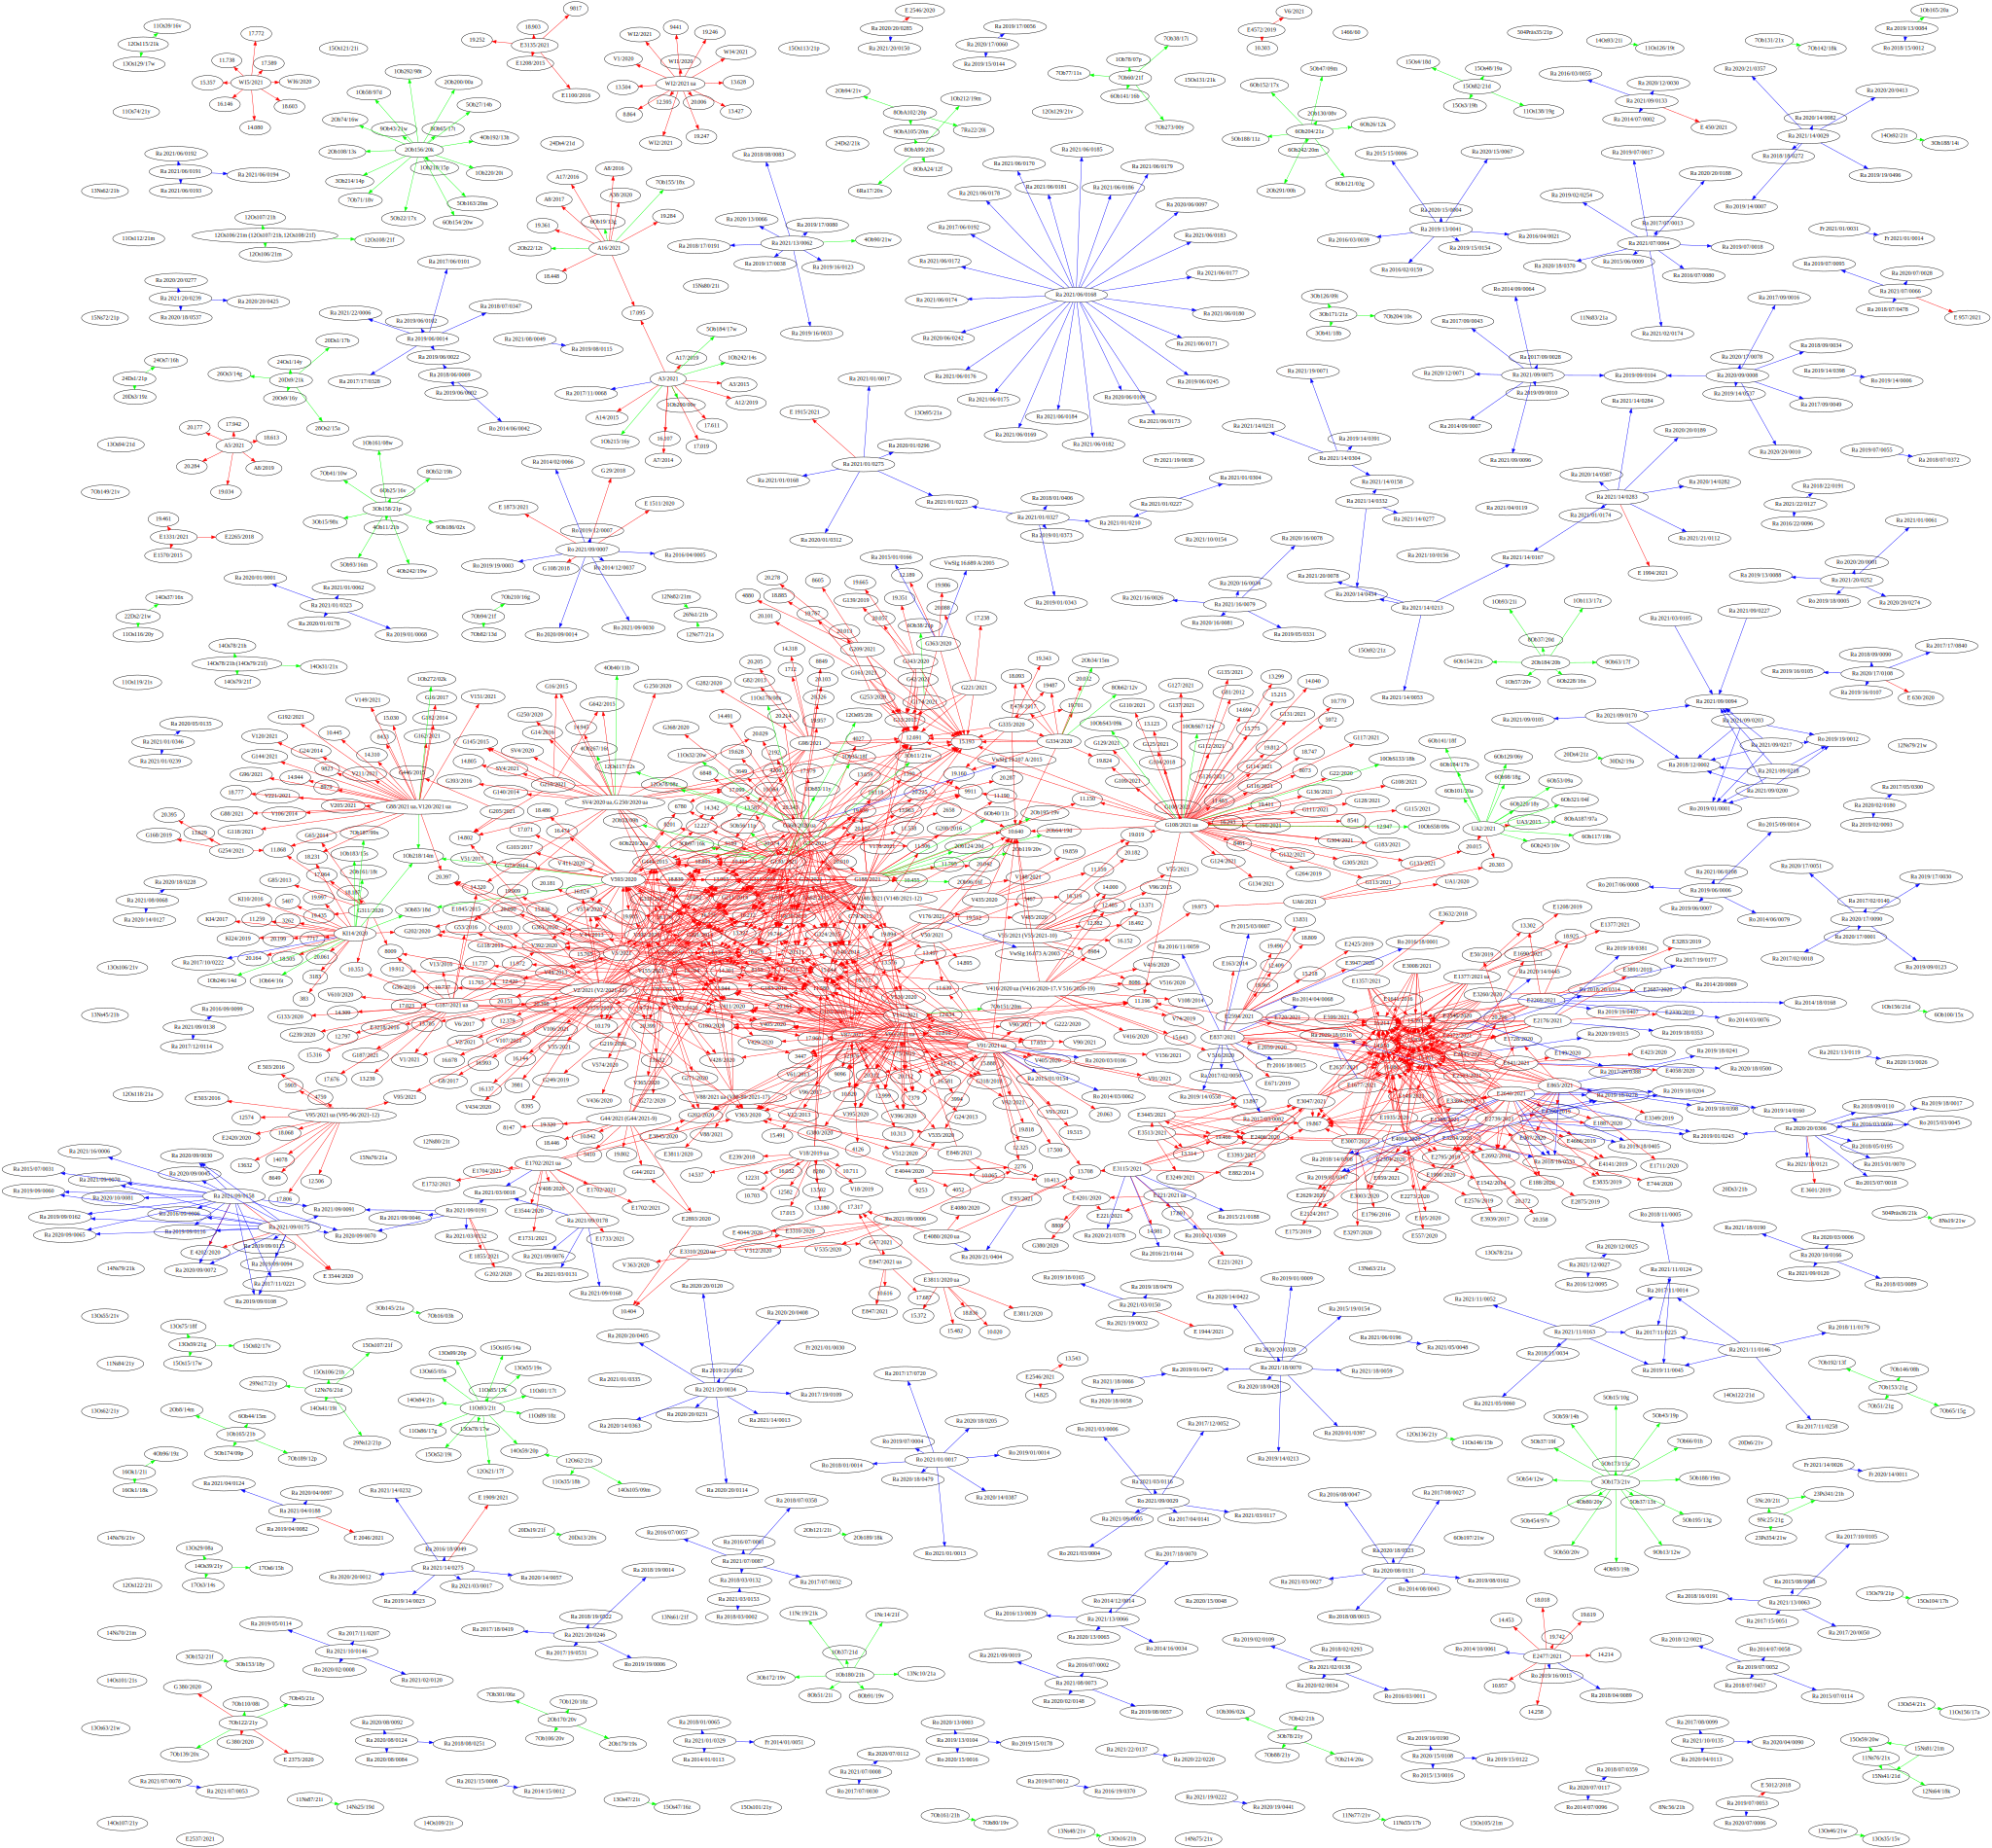

In [42]:
dot # create graph - this may take a while if graph is large

In [ ]:
#Show Graph in lokal jupyter-lab
dot.render(format='svg', view=True)

'Digraph.gv.svg'

## 3.2 Create graph using neo4j

Ein neo4j-Graph soll erstellt werden

In [ ]:
!pip install py2neo
from py2neo import Graph, Node, Relationship

     |████████████████████████████████| 177 kB 7.4 MB/s 


In [ ]:
#Change theese to use other database
neo4j_url="ADD_BOLT_URL"
neo4j_user="ADD_USER"
neo4j_pwd="ADD_PASSWORD"

In [ ]:
#neo4j (Port) needs to be reachable - in case of Porblems check Firewall
#graph.delete_all() # uncomment, if graph should be redone
graph = Graph(neo4j_url, auth=(neo4j_user, neo4j_pwd))


In [ ]:
# for large datasets this functions takes a while
# could be optimized
def create_neo4j(dataframe,gericht:str):
    for row in dataframe.itertuples():
        # Create a Node for every decision
        graph.run('''MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})''')
        
        if (dataframe.loc[row.Index, 'OGH_citings']):
            for citing in dataframe.loc[row.Index, 'OGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:OGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_OGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        if (dataframe.loc[row.Index, 'VwGH_citings']):
            for citing in dataframe.loc[row.Index, 'VwGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VwGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VwGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        if (dataframe.loc[row.Index, 'VwGH_Slg_citings']):
            for citing in dataframe.loc[row.Index, 'VwGH_Slg_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VwGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VwGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        
        if (dataframe.loc[row.Index, 'VfGH_citings']):
            for citing in dataframe.loc[row.Index, 'VfGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VfGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VfGH]->(b)
'''
                #print(query)
                graph.run(query)
                
        if (dataframe.loc[row.Index, 'VfGH_Slg_citings']):
            for citing in dataframe.loc[row.Index, 'VfGH_Slg_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VfGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VfGH]->(b)
'''
                #print(query)
                graph.run(query)

In [ ]:
for organ, dataframe in dataframes.items():
    create_neo4j(dataframe,organ)

In [ ]:
query="CALL gds.graph.drop('pagerank')" # to make sure we make a new pagerank, lets drop any oldones
graph.run(query) # Error is normal if graph was not created before

graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,nodeFilter,relationshipFilter,density,creationTime,modificationTime,schema
pagerank,neo4j,,-1,null,null,MATCH (n) RETURN id(n) AS id,"MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target",1528,2080,null,null,0.0008914581168975886,datetime('2022-01-19T07:17:09.721423000+00:00'),datetime('2022-01-19T07:17:09.999870000+00:00'),"{relationships: {__ALL__: {}}, nodes: {__ALL__: {}}}"


In [ ]:
query="CALL gds.graph.create.cypher('pagerank','MATCH (n) RETURN id(n) AS id','MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target',{validateRelationships:false})"
graph.run(query)

nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
MATCH (n) RETURN id(n) AS id,"MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target",pagerank,1528,2080,238


In [ ]:
query = "CALL gds.pageRank.stream('pagerank') YIELD nodeId, score RETURN nodeId, gds.util.asNode(nodeId).GZ AS Entscheidung, score ORDER BY score DESC"


result_df = graph.query(query).to_data_frame()
print(result_df.head(11))

    nodeId     Entscheidung     score
0     1887  Ra 2021/09/0094  0.575000
1     2289           16.080  0.460764
2     2290           14.393  0.460764
3     2291           16.214  0.460764
4     2293           14.650  0.460764
5     2294           13.836  0.460764
6     2295           15.451  0.460764
7     2450           15.193  0.412518
8     2473           12.691  0.412518
9     1573        26Ns1/21b  0.405000
10    2502         G13/2015  0.378589


# 4 Statistical Analysis

Welche Behörde zitiert sich selbst am meisten?
Wie häufig zitieren sich Behörden untereinander?

In [43]:
def count_citings(dataframe):
    for cited_organ in ["OGH","VfGH","VfGH_Slg","VwGH","VwGH_Slg"]:
        dataframe['num_'+cited_organ+'_citings']=dataframe.apply(lambda x: len(x[cited_organ+'_citings']), axis=1)

In [44]:
for organ_dataframe in dataframes.values():
    count_citings(organ_dataframe)


In [46]:
for cited_organ in ["OGH","VwGH","VfGH","VwGH_Slg","VfGH_Slg"]:
    for organ, organ_dataframe in dataframes.items():
        
        print(organ+" cites "+str(cited_organ),organ_dataframe['num_'+cited_organ+'_citings'].sum())
    print("\n\n")

OGH cites OGH 178
VwGH cites OGH 2
VfGH cites OGH 57



OGH cites VwGH 0
VwGH cites VwGH 382
VfGH cites VwGH 60



OGH cites VfGH 3
VwGH cites VfGH 25
VfGH cites VfGH 513



OGH cites VwGH_Slg 0
VwGH cites VwGH_Slg 0
VfGH cites VwGH_Slg 3



OGH cites VfGH_Slg 0
VwGH cites VfGH_Slg 1
VfGH cites VfGH_Slg 856





In [47]:
def make_autopct(data):
    def my_autopct(pct):
        total = sum(data)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Number of decisions in dataset


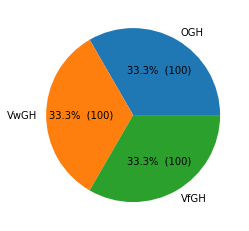

In [48]:
# number of decisions in dataset (to put the following plots into perspective)

# Creating dataset
label = ['OGH', 'VwGH', "VfGH"]
data = [len(dataframes['OGH'].index),len(dataframes['VwGH'].index),len(dataframes['VfGH'].index)]

# Creating plot
fig = plt.figure()
#plt.pie(data, labels = label, autopct='%.1f%%')
plt.pie(data, labels = label, autopct=make_autopct(data))
# show plot
print("Number of decisions in dataset:")
plt.show()



OGH citing distribution:


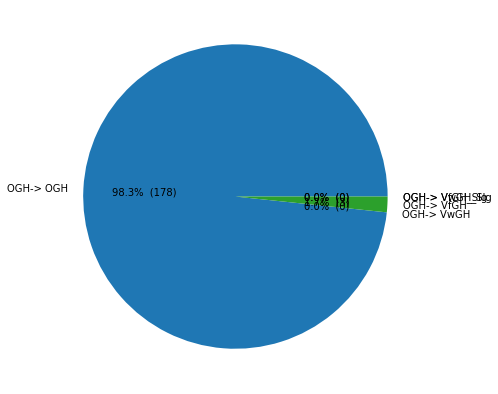

VwGH citing distribution:


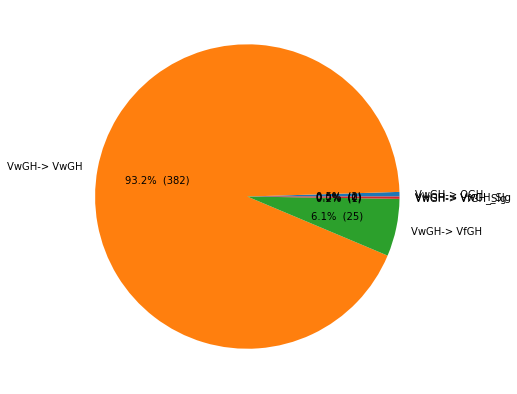

VfGH citing distribution:


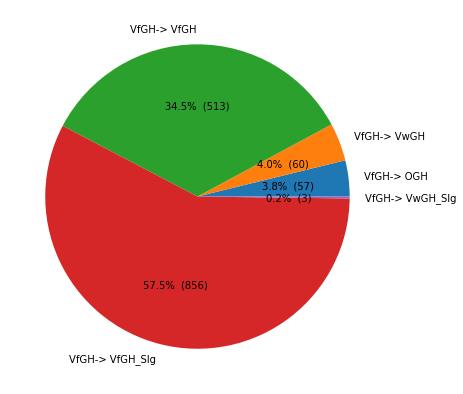

In [50]:
#plot citing distribution


for organ, organ_dataframe in dataframes.items():
    label = [organ+'-> OGH', organ+'-> VwGH', organ+"-> VfGH", organ+"-> VfGH_Slg",organ+"-> VwGH_Slg"]
    data = [organ_dataframe['num_OGH_citings'].sum(),organ_dataframe['num_VwGH_citings'].sum(),organ_dataframe['num_VfGH_citings'].sum(),organ_dataframe['num_VfGH_Slg_citings'].sum(),organ_dataframe['num_VwGH_Slg_citings'].sum()]
    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(data, labels = label, autopct=make_autopct(data))

    # show plot
    print(organ+" citing distribution:")
    plt.show()


Mean OGH citing distribution:


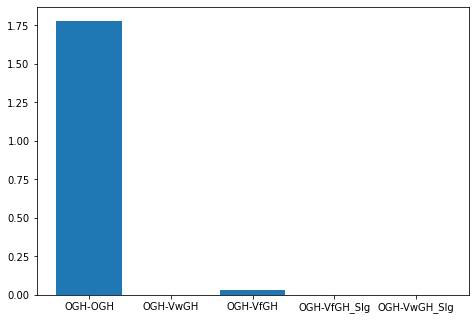

Mean VwGH citing distribution:


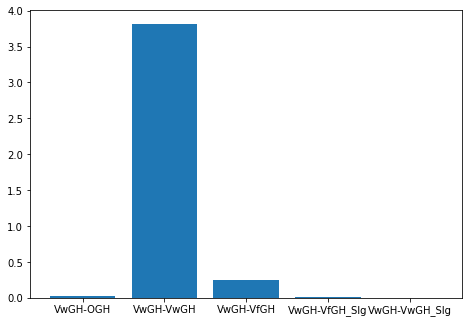

Mean VfGH citing distribution:


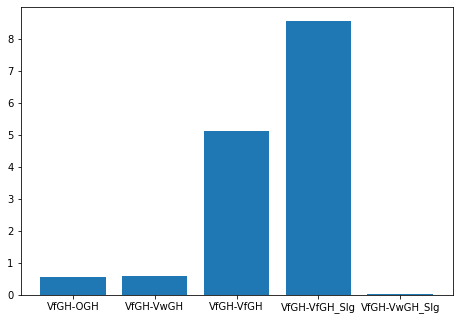

In [56]:
#plot mean citing distribution
for organ, organ_dataframe in dataframes.items():
    label = [organ+'-OGH', organ+'-VwGH', organ+"-VfGH", organ+"-VfGH_Slg",organ+"-VwGH_Slg"]
    data = [organ_dataframe['num_OGH_citings'].mean(),organ_dataframe['num_VwGH_citings'].mean(),organ_dataframe['num_VfGH_citings'].mean(),organ_dataframe['num_VfGH_Slg_citings'].mean(),organ_dataframe['num_VwGH_Slg_citings'].mean()]
    # Creating plot
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.bar(label,data)
    #plt.pie(data, labels = label, autopct=make_autopct(data))

    # show plot
    print("Mean "+organ+" citing distribution:")
    plt.show()

In [57]:
def count_unique_citings(dataframe,organ:str):
    if organ not in ["OGH","VfGH","VwGH","VfGH_Slg","VwGH_Slg"]:
        raise ValueError('Organ unknow')
    unique_citings = {}
    for row in dataframe.itertuples():
        if (dataframe.loc[row.Index, organ+'_citings']):
            for citing in dataframe.loc[row.Index, organ+'_citings']:
                if citing in unique_citings.keys():
                    unique_citings[citing] += 1
                else:
                    unique_citings[citing] = 1
   
    unique_citings={k:v for k, v in sorted(unique_citings.items(), key=lambda item: item[1], reverse=True)} # Sort to reveal most cited
    return unique_citings

In [58]:
num_top_citings=3 # variable to quickly change output



    
unique_citings_OGH=["OGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"OGH").items(), num_top_citings)),"OGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VwGH").items(), num_top_citings)),"OGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VfGH").items(), num_top_citings)),"OGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VfGH_Slg").items(), num_top_citings)),"OGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VwGH_Slg").items(), num_top_citings))]
unique_citings_VwGH=["VwGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"OGH").items(), num_top_citings)),"VwGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VwGH").items(), num_top_citings)),"VwGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VfGH").items(), num_top_citings)),"VwGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VfGH_Slg").items(), num_top_citings)),"VwGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VwGH_Slg").items(), num_top_citings))]
unique_citings_VfGH=["VfGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"OGH").items(), num_top_citings)),"VfGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VwGH").items(), num_top_citings)),"VfGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VfGH").items(), num_top_citings)),"VfGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VfGH_Slg").items(), num_top_citings)),"VfGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VwGH_Slg").items(), num_top_citings))]



print("OGH-top-citings",unique_citings_OGH)

print("VwGH-top-citings",unique_citings_VwGH)

print("VfGH-top-citings",unique_citings_VfGH)



print("--------------------------------------------")
df_all_combined= pd.concat([dataframes['OGH'], dataframes['VwGH'], dataframes['VfGH']], ignore_index=True)
unique_citings_combined={}
for organ in dataframes:
    unique_citings_combined[organ] = dict(itertools.islice(count_unique_citings(df_all_combined,organ).items(), num_top_citings))
    print(organ + " overall top citings",(unique_citings_combined[organ]))

    



OGH-top-citings ['OGH->OGH:', {'14Os59/20p': 2, '26Ns1/21b': 2, '9ObA105/20m': 2}, 'OGH->VwGH:', {}, 'OGH->VfGH:', {'E 2375/2020': 1, 'G 380/2020': 1, 'G 380/2020 ': 1}, 'OGH->VfGH_Slg:', {}, 'OGH->VwGH_Slg:', {}]
VwGH-top-citings ['VwGH->OGH:', {'4Ob90/21w': 1, '1Ob165/20a': 1}, 'VwGH->VwGH:', {'Ra 2021/09/0094': 7, 'Ra 2018/12/0002': 5, 'Ro 2019/19/0012': 4}, 'VwGH->VfGH:', {'E 4202/2020': 2, 'E 3544/2020': 2, 'E 1944/2021': 1}, 'VwGH->VfGH_Slg:', {'2276': 1}, 'VwGH->VwGH_Slg:', {}]
VfGH-top-citings ['VfGH->OGH:', {'1Ob218/14m': 3, '3Ob83/18d': 2, '1Ob272/02k': 1}, 'VfGH->VwGH:', {'Ra 2018/18/0533': 4, 'Ra 2019/18/0278': 4, 'Ra 2020/18/0516': 3}, 'VfGH->VfGH:', {'V573/2020': 11, 'V411/2020': 11, 'G444/2015': 11}, 'VfGH->VfGH_Slg:', {'14.393': 25, '13.836': 25, '14.650': 25}, 'VfGH->VwGH_Slg:', {'VwSlg 16.073 A/2003': 1, 'VwSlg 16.689 A/2005': 1, 'VwSlg 19.107 A/2015': 1}]
--------------------------------------------
OGH overall top citings {'1Ob218/14m': 3, '14Os59/20p': 2, '26Ns1/21